In [1]:
%autosave 100

Autosaving every 100 seconds


Import all neccessary libraries

In [2]:
import numpy as np
import pandas as pd

# for PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# for classification with cross-validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Define utility functions

In [3]:
def load_dataset():
    labels = pd.read_csv("data/Class_labels.txt", sep="\t", header=0, index_col=1)

    df_list = [pd.read_csv("features_cd/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_cd = data.T

    df_list = [pd.read_csv("features_uc/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_uc = data.T
    
    df_list = [pd.read_csv("features_nonibd/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_nonibd = data.T
    
    data = pd.concat([data_cd, data_uc, data_nonibd], axis=1, ignore_index=True)
    lbls = np.array([labels.loc[i, "group"] for i in data.index])

    return data, lbls

Apply PCA to data

In [4]:
data, labels = load_dataset()
pca = PCA(n_components=2)
values = pca.fit_transform(data)

Create PCA plot

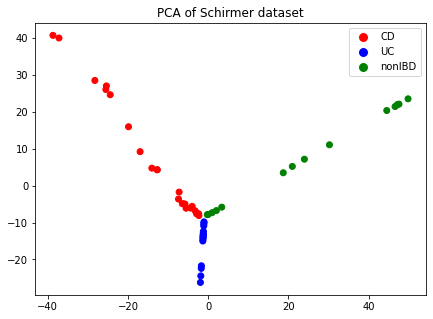

In [5]:
colors = dict(zip(['CD', 'UC', 'nonIBD'], ['r', 'b', 'g']))

plt.figure(figsize=(7, 5))

plt.scatter(values[:, 0], values[:, 1], color=[colors[i] for i in labels])
legend_elements = [Line2D([], [], marker='o', color='w', label='CD', markerfacecolor='r', markersize=10),
                   Line2D([], [], marker='o', color='w', label='UC', markerfacecolor='b', markersize=10),
                   Line2D([], [], marker='o', color='w', label='nonIBD', markerfacecolor='g', markersize=10)]

plt.legend(handles=legend_elements)
plt.title("PCA of Schirmer dataset")
plt.show()

PCA shows good separation of samples into three categories.
Now let's try to train Random Forest classification model.

Firstly, let's deal with 3-class problem and get accuracy using KFold splits.

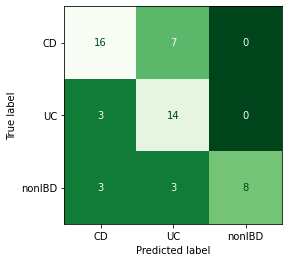

Accuracy: 0.7


In [6]:
data, labels = load_dataset()

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=50)
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['CD', 'UC', 'nonIBD'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))

Secondly, let's examine in details 2-class IBD vs nonIBD problem

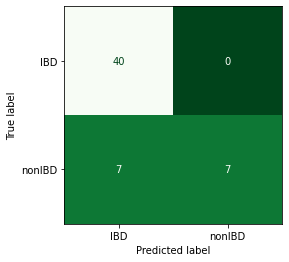

Accuracy: 0.87


In [7]:
data, labels = load_dataset()
labels = np.where(~np.isin(labels, ['CD', 'UC']), labels, 'IBD')

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=50)
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['IBD', 'nonIBD'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))

Finally, let's examine in details 2-class CD vs UC problem

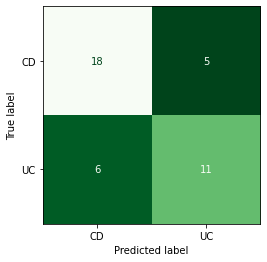

Accuracy: 0.72


In [8]:
data, labels = load_dataset()
i = np.where(np.isin(labels, ['CD', 'UC']))[0]
data = data.iloc[i, :]
labels = labels[i]

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=50)
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['CD', 'UC'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))